In [4]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier

In [23]:
import torchvision.models as models
import torch.nn as nn
from torch import cat
vgg16 = models.vgg16()

In [ ]:
momentum = 0.9
weight_decay = 0.0005
batch_size = 16
learn_rate = [1e-3, 1e-4, 1e-5]
learn_amounts = [40000, 10000, 10000]

In [ ]:
def FEM(i, j, l, upper_layer):
    enhanced_neuron = torch.cat()

In [20]:
truncated_model = nn.Sequential(*list(vgg16.children()))[:-1]

## Begin Second Attempt

Note: referenced from https://github.com/timesler/facenet-pytorch/blob/master/examples/face_tracking.ipynb

In [25]:
from facenet_pytorch import MTCNN
import torch
import numpy as np
import cv2

In [50]:
import matplotlib.pyplot as plt

In [27]:
mtcnn = MTCNN(keep_all=True, device='cpu')

In [79]:
frame = cv2.cvtColor(cv2.imread('samples/input_img_with_face.jpeg'), cv2.COLOR_BGR2RGB)

[ WARN:0@13375.420] global loadsave.cpp:244 findDecoder imread_('samples/input_img_with_face.jpeg'): can't open/read file: check file path/integrity


error: OpenCV(4.7.0) /Users/opencv-cn/GHA-OCV-3/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [80]:
boxes, confidence = mtcnn.detect(frame)

In [81]:
masked = frame.copy()

for i, detected in enumerate(boxes):
    if confidence[i] < .5:
        continue
    
    [x1, y1, x2, y2] = detected
    
    # adjust mask smaller so face replacement has more to work with
    x_adj = abs(x2-x1) / 8
    y_adj = abs(y2-y1) / 8
    x1 = int(x1 + x_adj)
    x2 = int(x2 - x_adj)
    y1 = int(y1 + y_adj)
    y2 = int(y2 - y_adj)
    
    masked[y1:y2,x1:x2] = np.random.rand(y2-y1, x2-x1, 3) * 255

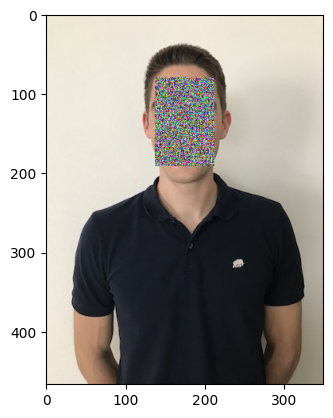

In [82]:
plt.imshow(masked)

## Implementation of Face Detector

Note: Referred to the paper at https://kpzhang93.github.io/MTCNN_face_detection_alignment/paper/spl.pdf

In [76]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

training_data = torchvision.datasets.WIDERFace(
    root="widerface",
    split="train",
    download=True,
    transform=ToTensor()
)

test_data = torchvision.datasets.WIDERFace(
    root="widerface",
    split="val",
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

94240768.0 bytes


KeyboardInterrupt: 

In [77]:
import torch.nn as nn
import numpy as np
import torch

class FaceDetector(nn.Module):
    def __init__(self, in_channels=3):
        super(FaceDetector, self).__init__()
        
        self.p_net = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, stride=1, padding=1),
            nn.PReLU(10),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(10, 16, kernel_size=3, stride=1, padding=1),
            nn.PReLU(16),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.PReLU(32),
        )
        self.p_face = nn.Linear(32, 2)
        self.p_bound = nn.Linear(32,  4)
        self.p_landmark = nn.Linear(32,  10)
        
        self.r_net = nn.Sequential(
            nn.Conv2d(3, 28, kernel_size=3, stride=1, padding=1),
            nn.PReLU(28),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            nn.Conv2d(28, 48, kernel_size=3, stride=1, padding=1),
            nn.PReLU(48),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            nn.Conv2d(48, 64, kernel_size=2, stride=1, padding=1),
            nn.PReLU(64),
            nn.Linear(64, 128),
            nn.PReLU(128)
        )
        self.r_face = nn.Linear(128, 2)
        self.r_bound = nn.Linear(128,  4)
        self.r_landmark = nn.Linear(128, 10)
        
        self.o_net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.PReLU(32),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.PReLU(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.PReLU(64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=1),
            nn.PReLU(128),
            nn.Linear(128, 256),
            nn.PReLU(256),
        )
        self.o_face = nn.Linear(256, 2)
        self.o_bound = nn.Linear(256,  4)
        self.o_landmark = nn.Linear(256,  10)


    
    def p_forward(self, x):
        # assume x has already been resized to appropriate size 12x12
        x1 = self.p_net(x)
        face = self.p_face(x1)
        bounds = self.p_bound(x1)
        landmark = self.p_landmark(x1)
        return face, bounds, landmark
    
    def r_forward(self, x):
        # assume x has already been resized to appropriate size 24x24
        x1 = self.r_net(x)
        face = self.r_face(x1)
        bounds = self.r_bound(x1)
        landmark = self.r_landmark(x1)
        return face, bounds, landmark
    
    def o_forward(self, x):
        # assume x has already been resized to appropriate size 48x48
        x1 = self.o_net(x)
        face = self.o_face(x1)
        bounds = self.o_bound(x1)
        landmark = self.o_landmark(x1)
        return face, bounds, landmark
        
        

In [78]:
face_detector = FaceDetector()

classify_loss = nn.BCELoss()
bound_loss = nn.MSELoss()
landmark_loss = nn.MSELoss()

optimizer = torch.optim.SGD(face_detector.parameters(), lr = 0.002)


In [1]:
def detect_faces(image_in, detector):
    im_12 = cv2.resize(image_in, [12, 12, 3])
    im_24 = cv2.resize(image_in, [24, 24, 3])
    im_48 = cv2.resize(image_in, [48, 48, 3])
    
    face, bounds, landmark = detector.p_forward(im_12)
    kept_idxs = torchvision.ops.nms(bounds, face, 0.5)
    face_12 = face[kept_idxs]
    bounds_12 = bounds[kept_idxs]
    
    face, bounds, landmark = detector.r_forward(im_24)
    bounds = torch.cat(bounds, bounds_12*2)
    face = torch.cat(face, face_12)
    kept_idxs = torchvision.ops.nms(bounds, face, 0.7)
    face_24 = face[kept_idxs]
    bounds_24 = bounds[kept_idxs]
    
    face, bounds, landmark = detector.o_forward(im_48)
    bounds = torch.cat(bounds, bounds_24*2)
    face = torch.cat(face, face_24)
    kept_idxs = torchvision.ops.nms(bounds, face, 0.7)
    face_48 = face[kept_idxs]
    bounds_48 = bounds[kept_idxs]
    landmark_48 = landmark[kept_idxs]
    
    return face_48, bounds_48, landmark_48

In [ ]:
def evaluate_model(classify_loss, bound_loss, landmark_loss, face_detector, test_dataloader):
    mean_classify_loss, mean_bound_loss, mean_landmark_loss = 0, 0, 0
    for image in test_dataloader:
        image = image.to(device)
        
        estimated_label, estimated_bounds, estimated_landmarks = detect_faces(image)
        
        mean_classify_loss += classify_loss(true_label, estimated_label)
        mean_bound_loss += bound_loss(true_bound, estimated_bounds)
        mean_landmark_loss += landmark_loss(true_landmark, estimated_landmarks)
        
    mean_classify_loss /= len(test_dataloader)
    mean_bound_loss /= len(test_dataloader)
    mean_landmark_loss /= len(test_dataloader)
    return mean_classify_loss, mean_bound_loss, mean_landmark_loss

In [ ]:
num_epochs = 30
best_loss = float('inf')
patience = 5

for epoch in range(num_epochs):
    for i, image in enumerate(train_dataloader):
        # Resize the images and masks to a consistent size
        image = image.to(device)
    
        # detect faces with p, r, o nets
        estimated_label, estimated_bounds, estimated_landmarks = detect_faces(image, face_detector)
        
        loss = classify_loss(true_label, estimated_label) + bound_loss(true_bound, estimated_bounds) + landmark_loss(true_landmark, estimated_landmarks)

        # back-prop the losses
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if i % 10000 == 0:
            fig, axs = plt.subplots(1, 4, figsize=(15, 5))
            axs[0].imshow(image)
            axs[0].set_title("Original Image")
            axs[1].imshow(detected_face(image, estimated_bounds))
            axs[1].set_title("Detected Faces")

            for ax in axs:
                ax.set_xticks([])
                ax.set_yticks([])

    plt.show()
    
    # Evaluate after each epoch
    mean_face_loss, mean_bound_loss, mean_landmark_loss = evaluate_model(classify_loss, bound_loss, landmark_loss, face_detector, test_dataloader)
    print(f"Epoch: {epoch}, Face Loss: {mean_face_loss:.4f}, Bound Loss: {mean_bound_loss:.4f}, Landmark Loss: {mean_landmark_loss:.4f}")

    
    if mean_bound_loss < best_loss:
        best_loss = mean_bound_loss
        best_net = copy.deepcopy(face_detector.state_dict())
        # Save the best models
        torch.save(best_net, os.path.join(save_path, 'face_detector.pth'))

        counter = 0
    else:
        counter += 1

    # Check for early stopping
    if counter >= patience:
        print("Early stopping triggered.")
        break